In [61]:
import numpy as np
import torch
import mm3dtestdata as mm3d
import fusecam
from fusecam.geometric import space
from fusecam.geometric import embedplane
from fusecam.geometric import interpolate
from fusecam.manipimg import rotate_tensor_cube
import matplotlib.pyplot as plt
import einops

from torch.utils.data import TensorDataset, DataLoader

from dlsia.core.networks import sms3d

import torch.nn as nn
import torch.optim as optim



First we need to build test data, low res and high res.

In [19]:
scale = 64
border = 10
radius = 8

sigma_low = 3.0
sigma_high = 1.0


In [20]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, k0=1.1)
_, instance_map_0, class_map_0 = obj.fill()

/tmp/ipykernel_321701/3811926222.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', 3)


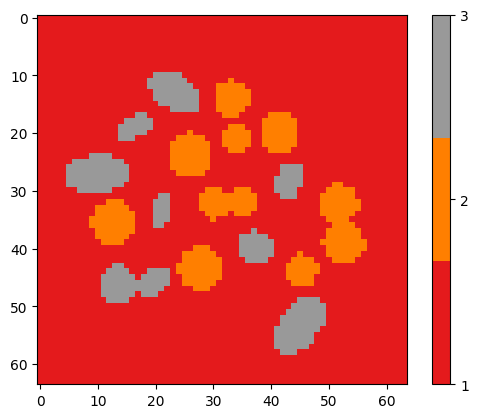

In [21]:
cmap = plt.cm.get_cmap('Set1', 3)
plt.imshow(class_map_0[32,...], cmap=cmap, interpolation='none')
cbar = plt.colorbar(ticks=[0,1,2,3] )#np.arange(np.min(0), np.max(3) + 1))
plt.show()

In [22]:
class_map_low = mm3d.blur_it(class_map_0, sigma=sigma_low)
class_map_high = mm3d.blur_it(class_map_0, sigma=sigma_high)

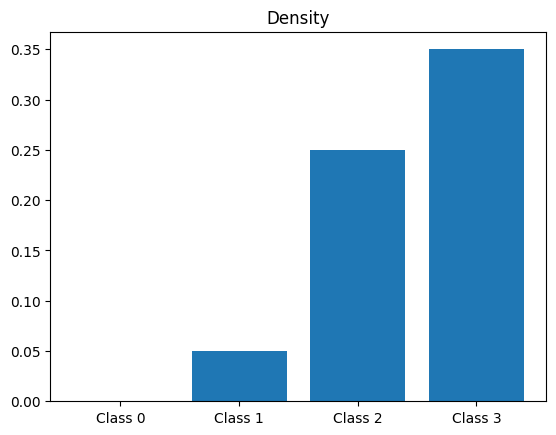

In [23]:
tomo_class_0 = np.array([0])
tomo_class_1 = np.array([0.05])
tomo_class_2 = np.array([0.25])
tomo_class_3 = np.array([0.35])
class_actions_tomo = np.column_stack([tomo_class_0,
                                      tomo_class_1,
                                      tomo_class_2,
                                      tomo_class_3]).T

plt.bar( ["Class 0", "Class 1", "Class 2", "Class 3"],class_actions_tomo.ravel() )
plt.title("Density")
plt.show()

In [24]:
low_map = mm3d.compute_weighted_map(class_map_low, class_actions_tomo)
high_map = mm3d.compute_weighted_map(class_map_high, class_actions_tomo)

low_map = low_map + mm3d.noise(low_map, 0.01, 0.0)
high_map = high_map + mm3d.noise(high_map, 0.01, 0.0)

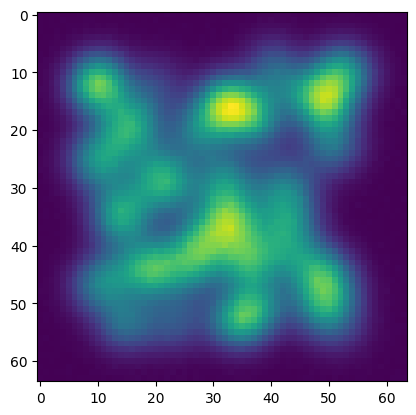

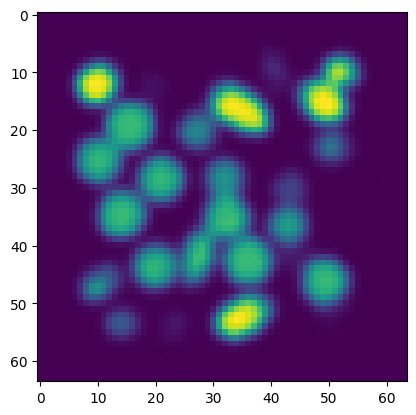

In [25]:
plt.imshow(low_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.show()

Now that we have data, I will use have to make the geometric objects

In [26]:
space_object = space.SpatialVolumeMetric(origin=(0,0,0),
                                         step_size=(1,1,1),
                                         orientation = torch.eye(3),
                                         translation = (0,0,0),
                                        )
plane_object = space.SpatialPlaneMetric(origin=(0,0),
                                         step_size=(1,1),
                                         orientation = torch.eye(2),
                                         translation = (0,0))

Now we have the two geometric objects, I want define a plane and get stuff going

In [27]:
u = torch.linspace(0,scale-1,scale)
U,V = torch.meshgrid(u,u, indexing='ij')
UV = torch.concat([U.flatten().reshape(1,-1), V.flatten().reshape(1,-1)]).T

x = torch.linspace(0,scale-1,scale)
X,Y,Z = torch.meshgrid(x,x,x, indexing="ij")
XYZ = torch.concat([X.flatten().reshape(1,-1), Y.flatten().reshape(1,-1), Z.flatten().reshape(1,-1),]).T 
print(UV.shape, XYZ.shape)

torch.Size([4096, 2]) torch.Size([262144, 3])


In [127]:
aligner_1 = embedplane.Plane3DAligner(
    normal=[0.0, 0.00, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//2]
)
point_on_plane_2D_1 = (scale//2,scale//2)
aligned_points_1 = aligner_1.align_points_to_3d(UV, point_on_plane_2D_1, rotation_angle=0)

aligner_2 = embedplane.Plane3DAligner(
    normal=[0.0, -1.0, 0.0], 
    point_on_plane=[scale//2, scale//2, scale//2]
)
point_on_plane_2D_2 = (scale//2,scale//2)
aligned_points_2 = aligner_2.align_points_to_3d(UV, point_on_plane_2D_2, rotation_angle=0)




In [128]:
indices_1, near_dist_1 = interpolate.find_nearest(XYZ, aligned_points_1, 5)
weights_1 = interpolate.compute_weights(near_dist_1, power=3.0, cutoff=2.0)

indices_2, near_dist_2 = interpolate.find_nearest(XYZ, aligned_points_2, 5)
weights_2 = interpolate.compute_weights(near_dist_2, power=3.0, cutoff=2.0)



In [138]:
funct_1 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_1, 
                                                                         weights_1)
funct_2 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_2, 
                                                                         weights_2)



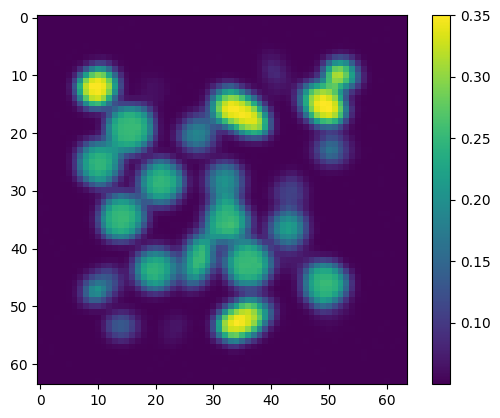

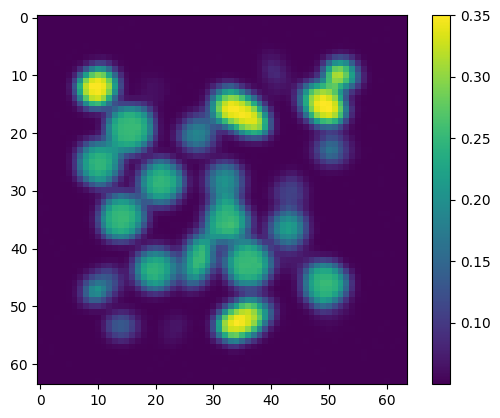

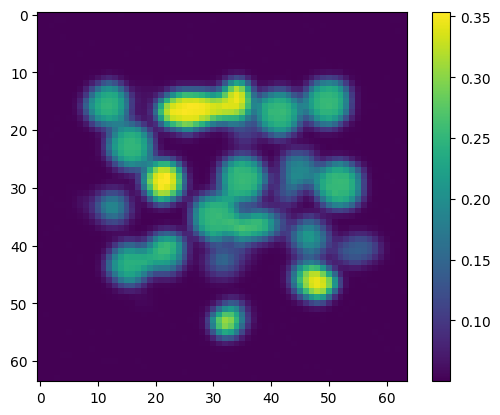

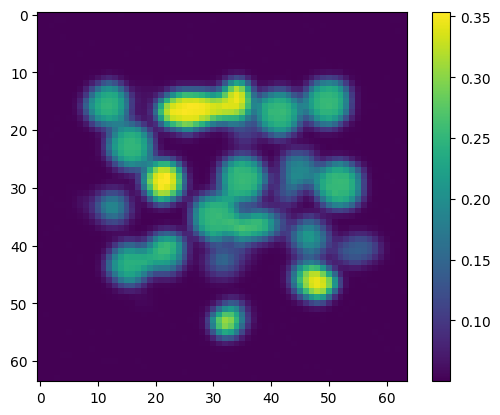

In [139]:
funct_1= einops.rearrange(funct_1, "(X Y) -> X Y ",X=scale, Y=scale)
plt.imshow(funct_1.numpy() )
plt.colorbar()
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.colorbar()
plt.show()

funct_2 = einops.rearrange(funct_2, "(X Y) -> X Y",X=scale, Y=scale)
plt.imshow(funct_2.numpy() )
plt.colorbar()
plt.show()


plt.imshow( high_map[0, :,scale//2,:]) 
plt.colorbar()
plt.show()




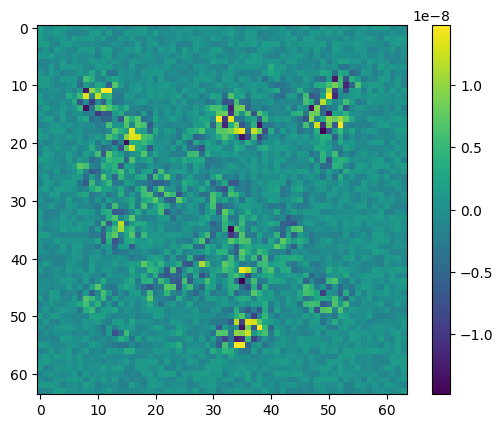

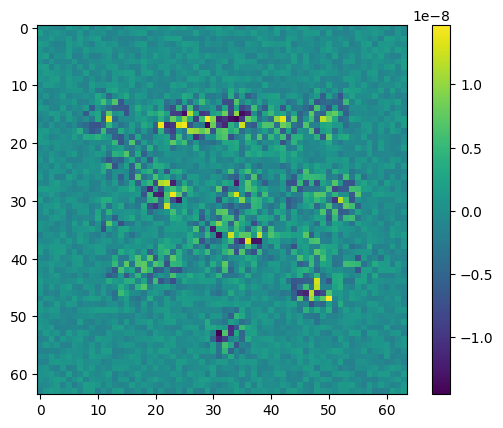

In [140]:
plt.imshow(funct_1.numpy() - high_map[0, :,:,scale//2])
plt.colorbar()
plt.show()

plt.imshow(funct_2.numpy() - high_map[0, :,scale//2,:])
plt.colorbar()
plt.show()


Build Data Loader

In [142]:
my_3d_maps = torch.concat([torch.Tensor(low_map).unsqueeze(0),
                           torch.Tensor(low_map).unsqueeze(0)])
my_2d_maps = torch.concat([torch.Tensor(high_map[0, :,:,32]).flatten().unsqueeze(0),
                           torch.Tensor(high_map[0, :,32,:]).flatten().unsqueeze(0)])
my_weights = torch.concat([weights_1.unsqueeze(0), weights_2.unsqueeze(0) ])
my_indices = torch.concat([indices_1.unsqueeze(0), indices_2.unsqueeze(0)])
                           

In [144]:
my_data = TensorDataset(my_3d_maps, my_2d_maps, my_weights, my_indices)                          
data_loader = DataLoader(my_data, batch_size=1) 

In [204]:
layers = 10
hidden_out_channels = [40]
dilation_choices = [1,2,3,]
sizing_settings = None
layer_probabilities = {'LL_alpha': 0.50,
                               'LL_gamma': 0.0,
                               'LL_max_degree': None,
                               'LL_min_degree': 1,
                               'IL': 0.995,
                               'LO': 0.995,
                               'IO': True}

net = sms3d.random_3DSMS_network(in_channels=1,
                         out_channels=1,
                         layers=layers,
                         dilation_choices=dilation_choices,
                         in_shape=(64, 64, 64),
                         out_shape=(64, 64, 64),
                         hidden_out_channels=None,
                         layer_probabilities=layer_probabilities,
                         sizing_settings=None,
                         dilation_mode="Edges",
                         network_type="Regression",
                         )

In [205]:
def train_model(net, loss_function, optimizer, dataloader, num_epochs, interpolate_function, device='cuda:0'):
    net.to(device)  # Move the network to the specified device
    net.train()  # Set the network to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0

        for batch in dataloader:
            img_tensor_3d, flat_2d_tensor, weights, indices = [item.to(device) for item in batch]

            # Forward pass
            outputs = net(img_tensor_3d)
            loss = 0.0
            for img3d, img2d, ws, idx in zip(outputs, flat_2d_tensor, weights, indices):
                img_flat = img3d.flatten()
                interp = interpolate_function(img_flat, idx, ws)
                not_nan_sel = ~torch.isnan(interp)

                # Compute loss
                loss += loss_function(interp[not_nan_sel], img2d[not_nan_sel])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

In [208]:
# Create an L1 loss function
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00151)  # You can adjust the learning rate as needed
train_model(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            100, 
            interpolate.inverse_distance_weighting_with_weights)


Epoch [1/100], Loss: 0.0004759969888255
Epoch [2/100], Loss: 0.00041333069384563714
Epoch [3/100], Loss: 0.0003975526778958738
Epoch [4/100], Loss: 0.0004001881607109681
Epoch [5/100], Loss: 0.00037059580790810287
Epoch [6/100], Loss: 0.0003745950380107388
Epoch [7/100], Loss: 0.0003737460501724854
Epoch [8/100], Loss: 0.0003489342489046976
Epoch [9/100], Loss: 0.0003466548369033262
Epoch [10/100], Loss: 0.0003503651241771877
Epoch [11/100], Loss: 0.0003496988501865417
Epoch [12/100], Loss: 0.0003411504585528746
Epoch [13/100], Loss: 0.00034182921808678657
Epoch [14/100], Loss: 0.0003405885654501617
Epoch [15/100], Loss: 0.00033730105496942997
Epoch [16/100], Loss: 0.0003349971666466445
Epoch [17/100], Loss: 0.00033579931186977774
Epoch [18/100], Loss: 0.0003347659367136657
Epoch [19/100], Loss: 0.00033360735687892884
Epoch [20/100], Loss: 0.0003337102971272543
Epoch [21/100], Loss: 0.0003319785027997568
Epoch [22/100], Loss: 0.0003297526709502563
Epoch [23/100], Loss: 0.00032986632140

In [209]:
with torch.no_grad():
    tmp3 = net.cpu()(torch.Tensor(low_map).unsqueeze(0))

In [210]:
m = (tmp1+tmp2+tmp3)/3.0
s = torch.sqrt((tmp1**2+tmp2**2+tmp3**2)/3.0 - m*m)

In [211]:
import napari

v = napari.view_image(low_map)
v.add_image(m.numpy()[0])
v.add_image(s.numpy()[0])
v.add_image(high_map)

/home/pzwart/anaconda3/envs/dlsia-new/lib/python3.9/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'high_map' at 0x7f10e55a9bb0>

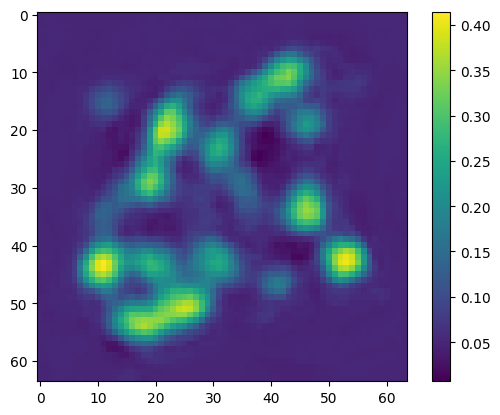

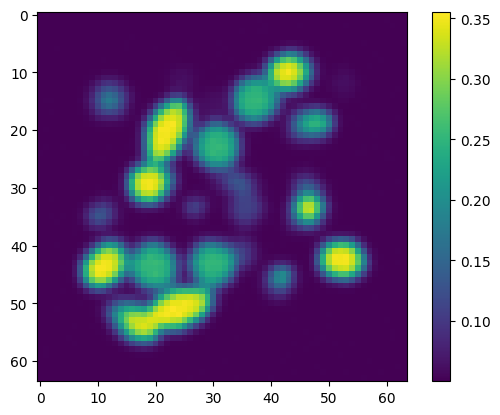

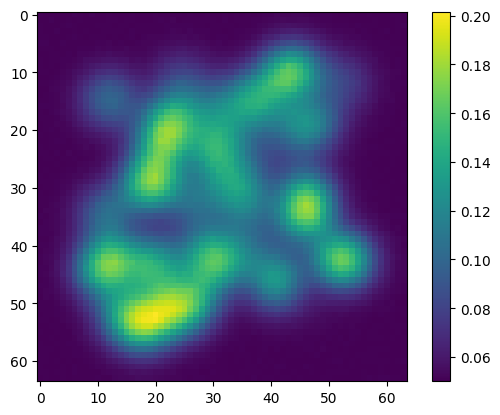

In [177]:
plt.imshow(m.numpy()[0, 0,:,:,scale//2-15])
plt.colorbar()
plt.show()

plt.imshow(high_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()


plt.imshow(low_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()